In [3]:
pip install pgmpy 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 11.2 MB/s 


In [4]:
from seaborn import distributions
from functools import partial
import numpy as np
import pandas as pd
from sklearn import preprocessing, metrics, model_selection
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import scipy
from pgmpy.estimators import HillClimbSearch, TreeSearch, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import arcsine, weibull_max,rice, norm, rdist, skewnorm

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
path = 'https://drive.google.com/file/d/1i_VkX57he5_QICWnX-egL2AHpW0yEDvd/view?usp=share_link'
path = 'https://drive.google.com/uc?id=' + path.split('/')[-2]

data = pd.read_csv(path, sep=',', header=0, encoding='utf-8')
data.drop(data.columns[0], axis=1, inplace=True)

data.head()

,id,long,lat,light,weather,nearby,road_conditions,category,severity,datetime,region,parent_region,participants_count,injured_count,dead_count,month,weekday,time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,1561495,37.608056,55.689444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Крупный торгов...","['Заснеженное', 'Отсутствие, плохая различимос...",Наезд на препятствие,С погибшими,2015-01-01 00:23:00,Котловка,Москва,2,1,1,January,Thursday,00:23:00,0,-6,1.1,2.8,1,71,01:47 PM,04:41 AM,08:59 AM,04:07 PM,-7,-10,-6,-10,12,100,96,0.0,1011,-6,2,263,9
1,2365887,91.543006,55.361608,"В темное время суток, освещение не включено",['Ясно'],[],['Сухое'],Наезд на препятствие,Тяжёлый,2015-01-01 00:50:00,Балахтинский район,Красноярский край,2,1,0,January,Thursday,00:50:00,-5,-12,0.0,5.8,1,71,02:00 PM,04:50 AM,09:20 AM,04:24 PM,-12,-16,-12,-16,15,68,96,0.0,1025,-12,2,212,7
2,1561392,37.752778,55.661667,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Нерегулируемый...",['Обработанное противогололедными материалами'],Наезд на пешехода,Тяжёлый,2015-01-01 01:00:00,Марьино,Москва,2,1,0,January,Thursday,01:00:00,0,-6,1.1,2.8,1,71,01:47 PM,04:41 AM,08:59 AM,04:07 PM,-6,-10,-6,-10,16,100,96,0.0,1010,-6,3,268,11
3,1913663,1.000000,1.000000,"В темное время суток, освещение включено",['Пасмурно'],[],['Мокрое'],Наезд на стоящее ТС,Легкий,2015-01-01 01:15:00,Василеостровский район,Санкт-Петербург,6,1,0,January,Thursday,01:15:00,2,1,0.0,1.5,1,71,01:57 PM,05:31 AM,10:00 AM,04:04 PM,1,-3,1,-3,22,91,97,0.0,1008,1,5,271,13
4,1561530,37.405833,55.649444,"В темное время суток, освещение включено",['Пасмурно'],"['Многоквартирные жилые дома', 'Выезд с прилег...","['Недостатки зимнего содержания', 'Заснеженное']",Столкновение,Тяжёлый,2015-01-01 01:39:00,Солнцево,Москва,3,1,0,January,Thursday,01:39:00,0,-6,1.1,2.8,1,71,01:47 PM,04:41 AM,08:59 AM,04:07 PM,-6,-10,-6,-10,16,100,96,0.0,1010,-6,3,268,11


In [7]:
df = pd.DataFrame(data={
    'maxtempC': data.maxtempC,
    'DewPointC': data.DewPointC,
    'pressure': data.pressure,
    'humidity': data.humidity,
    'visibility': data.visibility,
    'sunHour': data.sunHour,
    'HeatIndexC': data.HeatIndexC, 
    'winddirDegree': data.winddirDegree,
    'cloudcover':data.cloudcover,
    'mintempC': data.mintempC
})


df.head(10)

,maxtempC,DewPointC,pressure,humidity,visibility,sunHour,HeatIndexC,winddirDegree,cloudcover,mintempC
0,0,-7,1011,96,2,2.8,-6,263,100,-6
1,-5,-12,1025,96,2,5.8,-12,212,68,-12
2,0,-6,1010,96,3,2.8,-6,268,100,-6
3,2,1,1008,97,5,1.5,1,271,91,1
4,0,-6,1010,96,3,2.8,-6,268,100,-6
5,2,1,1008,97,7,1.5,1,271,87,1
6,2,1,1008,97,7,1.5,1,271,87,1
7,2,1,1008,97,7,1.5,1,271,87,1
8,-5,-12,1023,95,7,5.8,-11,197,88,-12
9,0,-5,1010,97,5,2.8,-5,277,100,-6


In [8]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142882 entries, 0 to 142881
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   maxtempC       142882 non-null  int64  
 1   DewPointC      142882 non-null  int64  
 2   pressure       142882 non-null  int64  
 3   humidity       142882 non-null  int64  
 4   visibility     142882 non-null  int64  
 5   sunHour        142882 non-null  float64
 6   HeatIndexC     142882 non-null  int64  
 7   winddirDegree  142882 non-null  int64  
 8   cloudcover     142882 non-null  int64  
 9   mintempC       142882 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 10.9 MB


In [9]:
variables_name = ['humidity', 'visibility', 'sunHour', 'HeatIndexC', 'winddirDegree', 'cloudcover', 'mintempC']
variables = df[variables_name]
targets_name = ['maxtempC', 'DewPointC', 'pressure']
targets = df[targets_name]

# Sampling

In [10]:
def ks_test(data, distribution, params, alpha = 0.05, N = 50):
    ks = stats.kstest(data.sample(N), distribution, params, N)
    if ks[1] > alpha:
        print(f'Kolmogorov test passed. Under the null hypothesis,\n the two {distribution} distributions are identical')
    else:
        print(f"Kolmogorov test failed. Hypothesis about {distribution} is false")
    print('\n',ks)
def cvm_test(data, distribution, params, alpha = 0.05):
    cvm = stats.cramervonmises(data.sample(50), distribution, params)
    if cvm.pvalue > alpha: 
        print(f"Cramer-von-Mises test passed. Hypothesis about that distribution \n have cumulative {distribution} distribution is true")
    else:
        print(f"Cramer-von-Mises failed. We reject the null hypothesis \n that the observed sample is drawn from a {distribution} distribution")
    print('\n',cvm)

In [11]:
def statistical_tests(data, distribution, params, alpha = 0.05, N = 50):
    ks_test(data, distribution, params, alpha, N = 50)
    print('\n')
    cvm_test(data, distribution, params, alpha)

# Тесты для maxtempC, DewPointC, pressure.

In [ ]:
temp_param=norm.fit(df['maxtempC'])
statistical_tests(df['maxtempC'], 'norm', temp_param)

Kolmogorov test failed. Hypothesis about norm is false

 KstestResult(statistic=0.25168338270111756, pvalue=0.002808281645275801)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative norm distribution is true

 CramerVonMisesResult(statistic=0.3110112030907081, pvalue=0.125715199498884)


In [ ]:
temp_param=rdist.fit(df['maxtempC'])
statistical_tests(df['maxtempC'], 'rdist', temp_param)

Kolmogorov test passed. Under the null hypothesis,
 the two rdist distributions are identical

 KstestResult(statistic=0.09779608489901626, pvalue=0.6886459403939388)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative rdist distribution is true

 CramerVonMisesResult(statistic=0.04010765233914801, pvalue=0.934353323397207)


In [ ]:
DewPointC_param=norm.fit(df['DewPointC'])
statistical_tests(df['DewPointC'], 'norm', DewPointC_param)

Kolmogorov test passed. Under the null hypothesis,
 the two norm distributions are identical

 KstestResult(statistic=0.06712061064420016, pvalue=0.9666847896838913)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative norm distribution is true

 CramerVonMisesResult(statistic=0.10189565612052065, pvalue=0.5774519323102077)


In [ ]:
DewPointC_param=rdist.fit(df['DewPointC'])
statistical_tests(df['DewPointC'], 'rdist', DewPointC_param)

Kolmogorov test passed. Under the null hypothesis,
 the two rdist distributions are identical

 KstestResult(statistic=0.12612679017320177, pvalue=0.37280394651103943)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative rdist distribution is true

 CramerVonMisesResult(statistic=0.20061170258493122, pvalue=0.2667377464947883)


In [ ]:
pressure_param=norm.fit(df['pressure'])
statistical_tests(df['pressure'], 'norm', pressure_param) 

Kolmogorov test failed. Hypothesis about norm is false

 KstestResult(statistic=0.21212340137673535, pvalue=0.018776034470530223)


Cramer-von-Mises test passed. Hypothesis about that distribution 
 have cumulative norm distribution is true

 CramerVonMisesResult(statistic=0.2161421476943789, pvalue=0.23858445377751136)


# Using inverse transform sampling

In [1]:
# Sampling from df
def inv_trans_sampling(data, num_samples=1000):

    # 1 step: Find the PDF
    bins = distributions._freedman_diaconis_bins(data.values)
    hist, bin_edges = np.histogram(data.values, bins=bins, density=True)

    # 2 step: Find CDF by the definition that CDF(x) = P (X <= x)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))

    # 3 step: Finding values inverse CDF using CDF by interpolation
    inversed_cdf = partial(np.interp, xp=cum_values, fp=bin_edges)
    #creating sampling data from uniform
    uniform_values = np.random.rand(num_samples)
    return inversed_cdf(uniform_values), bins

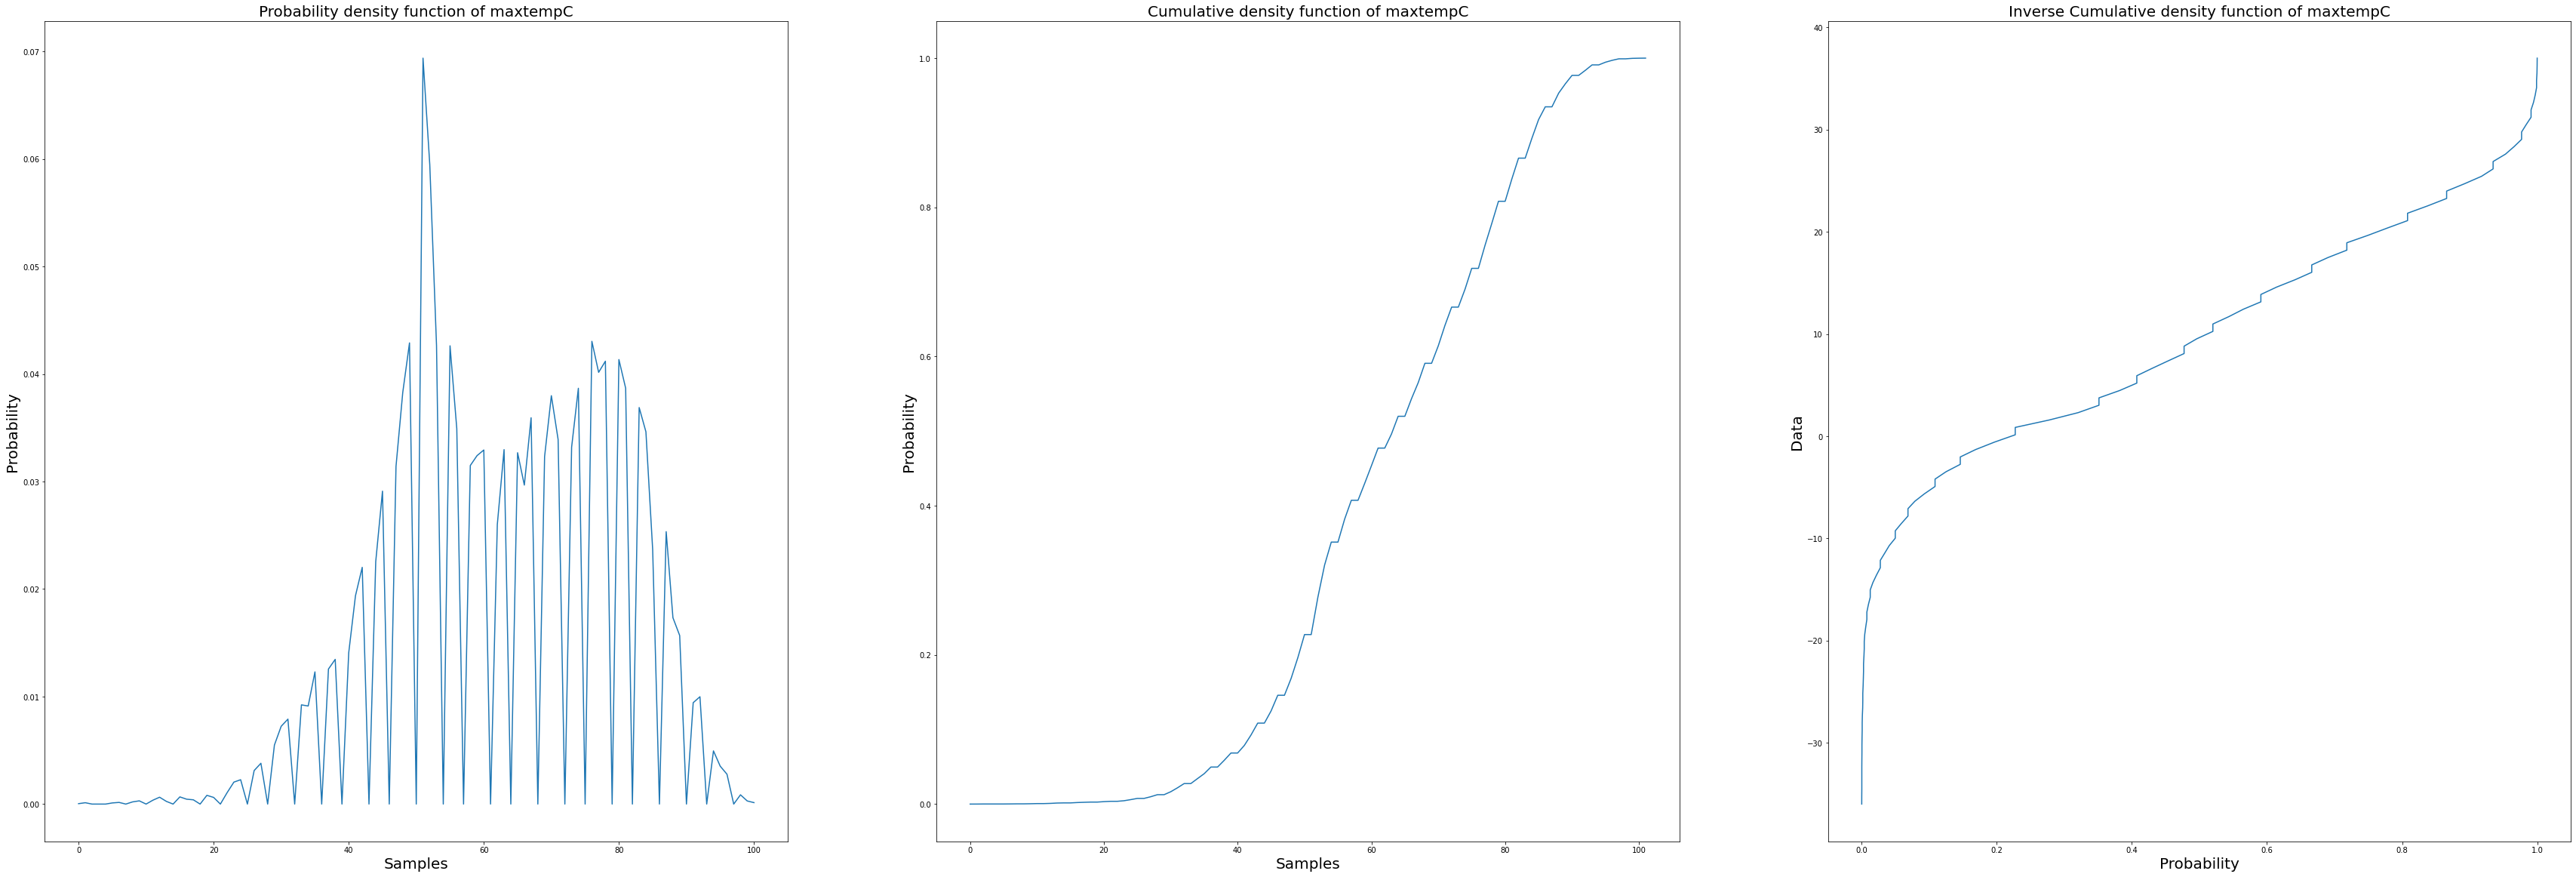

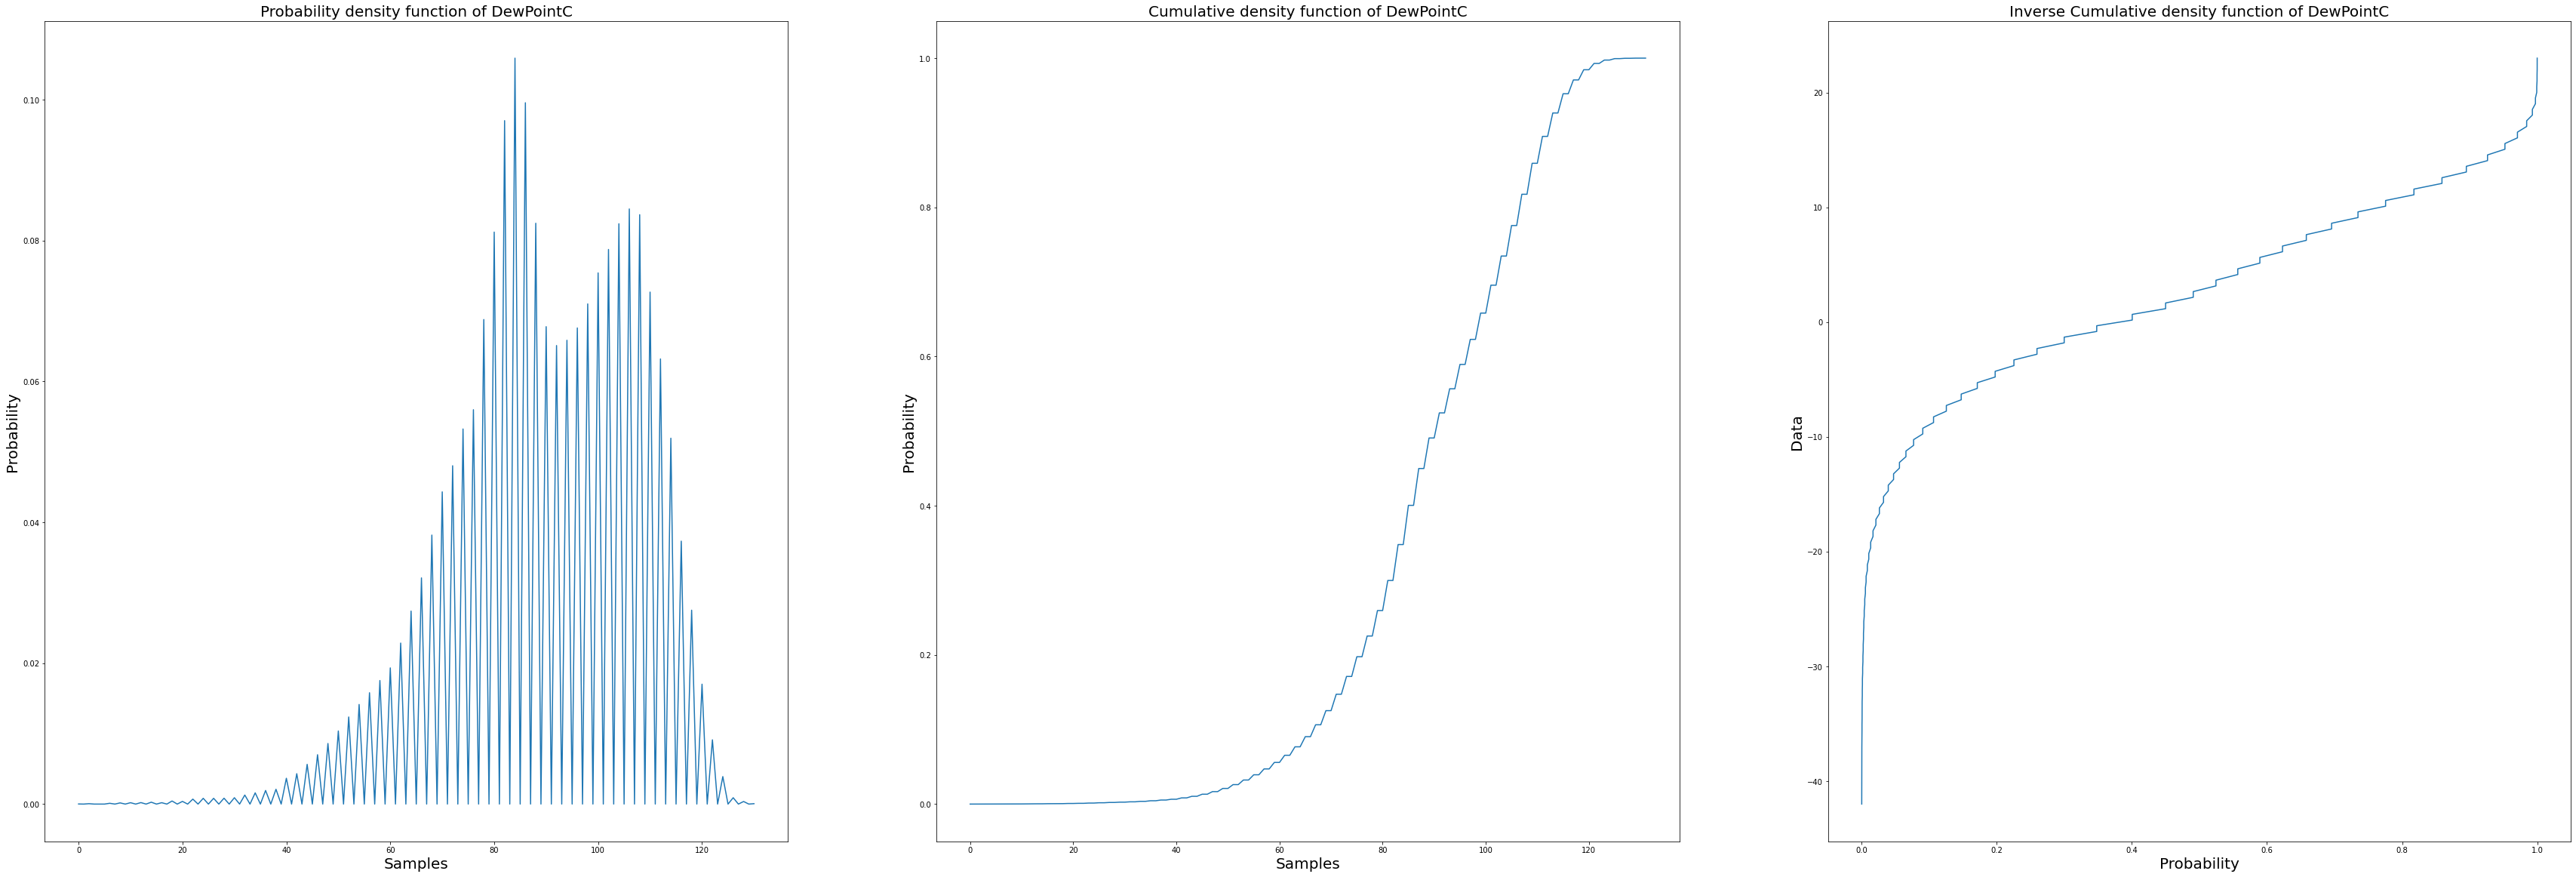

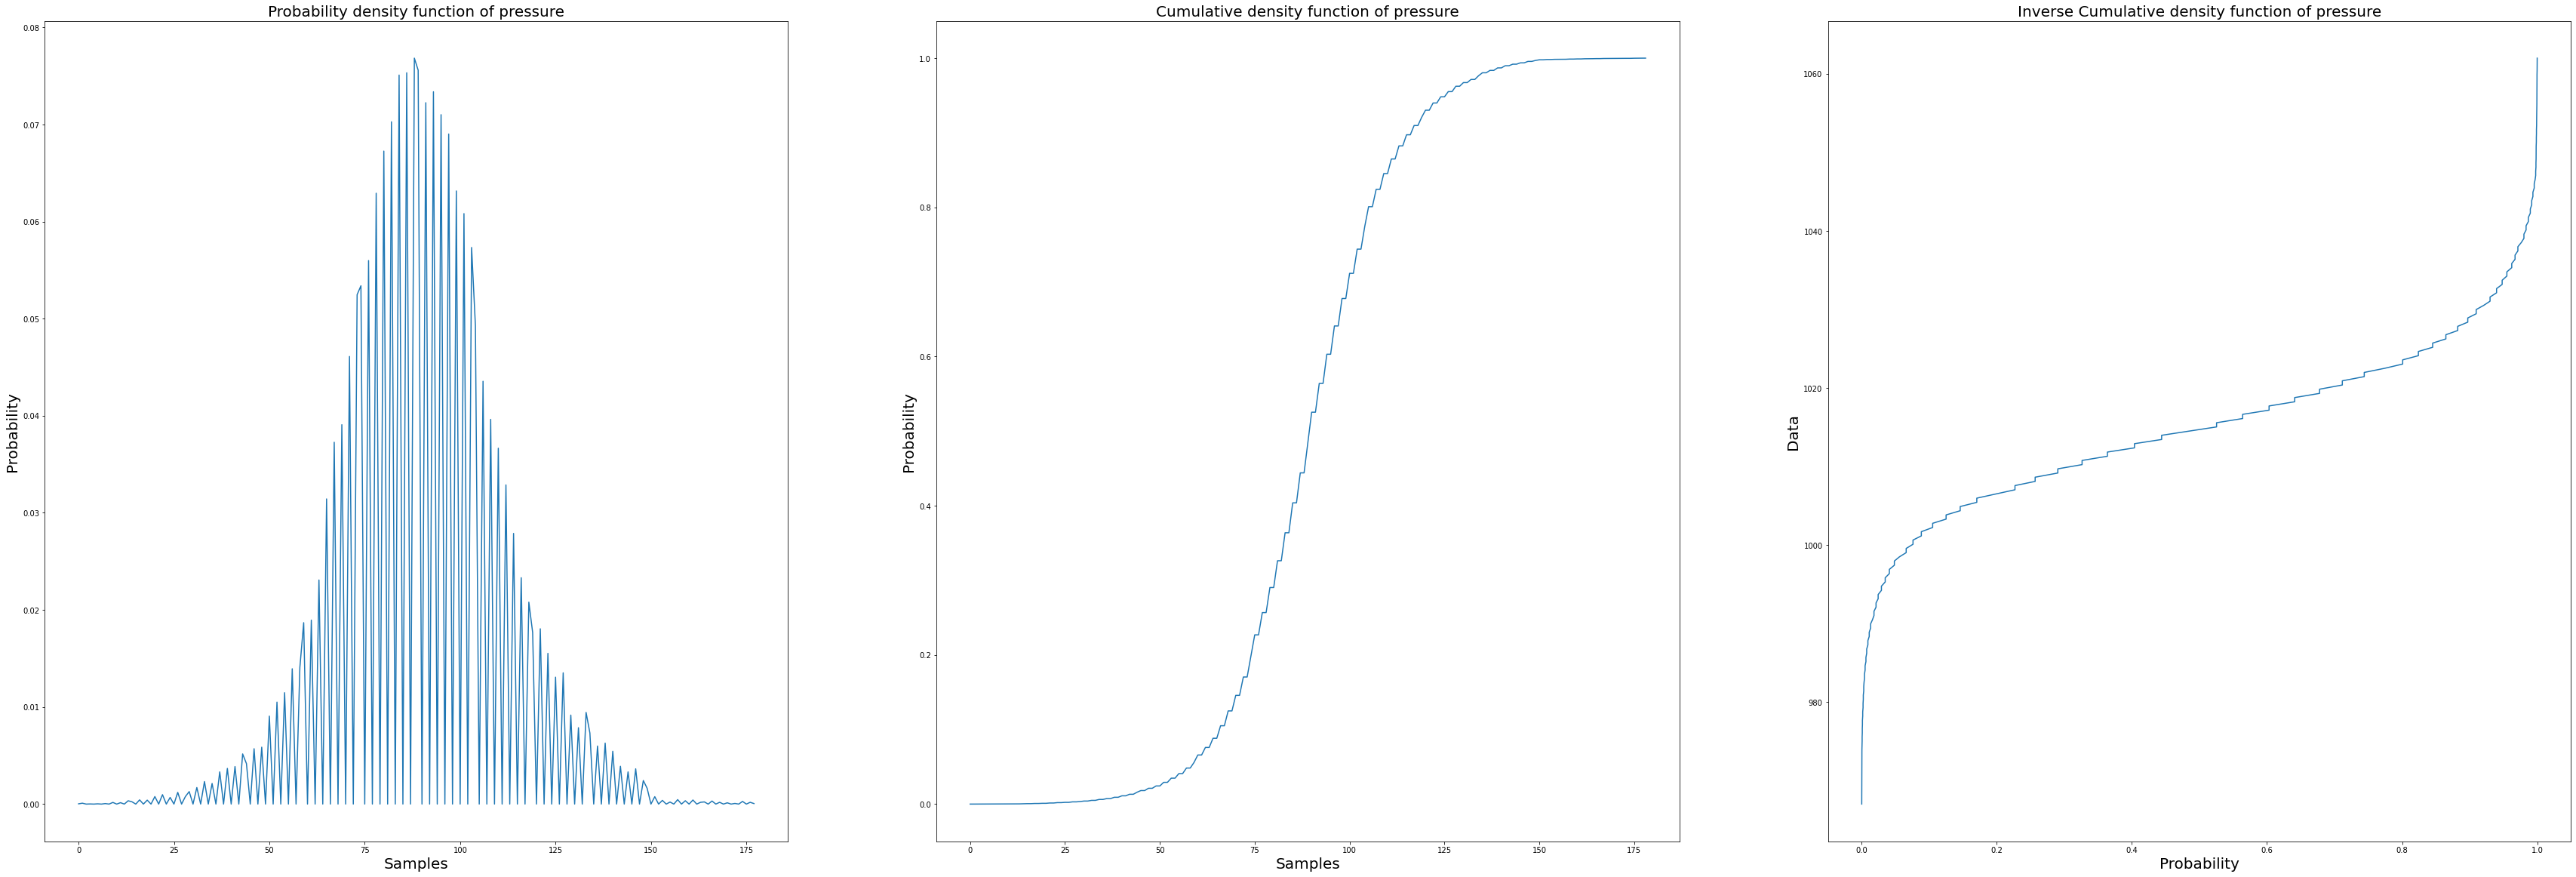

In [12]:
for name in targets_name:
    bins = distributions._freedman_diaconis_bins(df[name].values)
    hist, bin_edges = np.histogram(df[name], bins=bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist * np.diff(bin_edges))


    plt.figure(figsize=(60, 20))
    plt.subplot(1,3,1)
    plt.plot(hist)
    plt.ylabel('Probability', fontsize=20)
    plt.xlabel('Samples', fontsize=20)
    plt.title(f"Probability density function of {name}", fontsize=20)


    plt.subplot(1,3,2)
    plt.plot(cum_values)
    plt.ylabel('Probability', fontsize=20)
    plt.xlabel('Samples', fontsize=20)
    plt.title(f"Cumulative density function of {name}", fontsize=20)

    plt.subplot(1,3,3)
    plt.plot(cum_values, bin_edges)
    plt.ylabel('Data', fontsize=20)
    plt.xlabel('Probability', fontsize=20)
    plt.title(f"Inverse Cumulative density function of {name}", fontsize=20)
    #plt.savefig(f'./Pictures/INTF_{name}_1', bbox_inches='tight')

    plt.show()

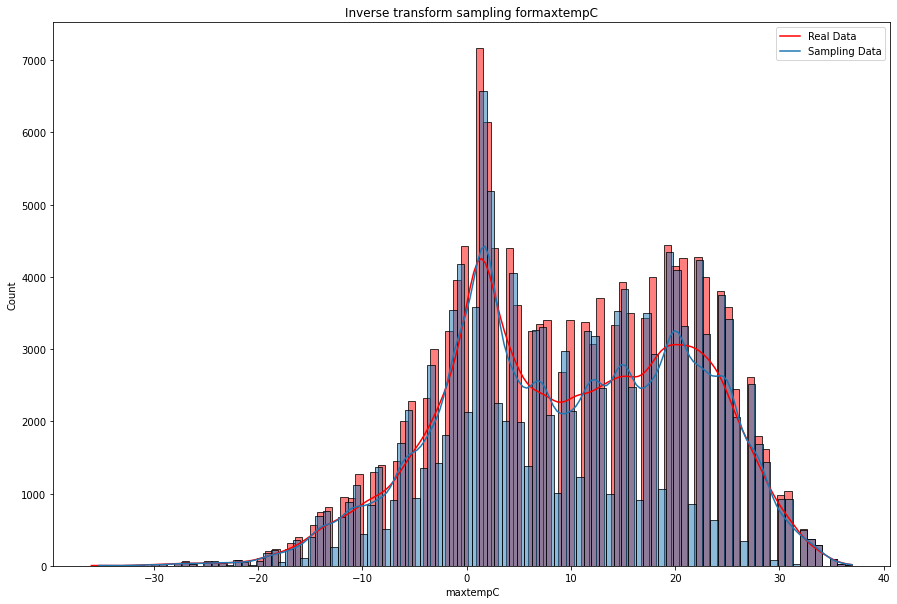

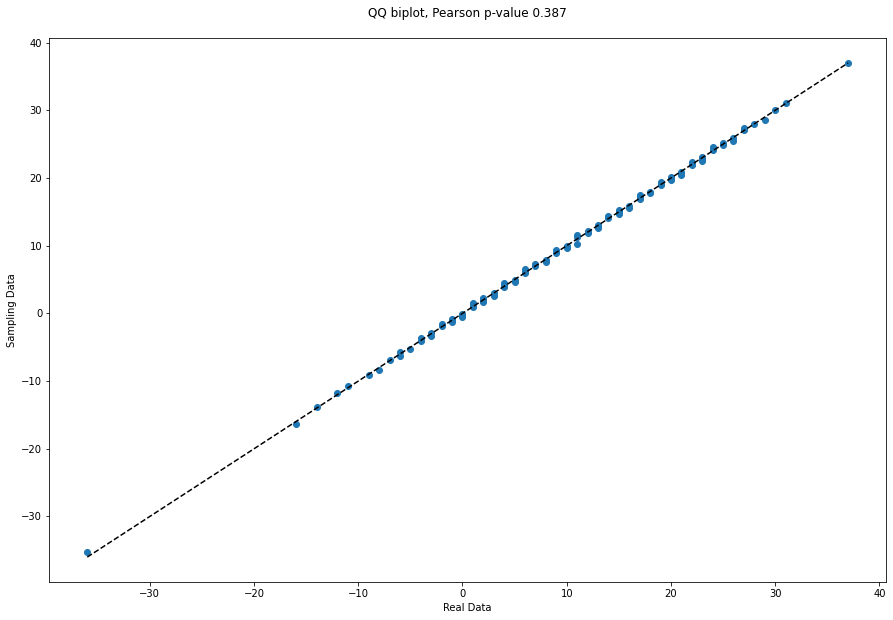

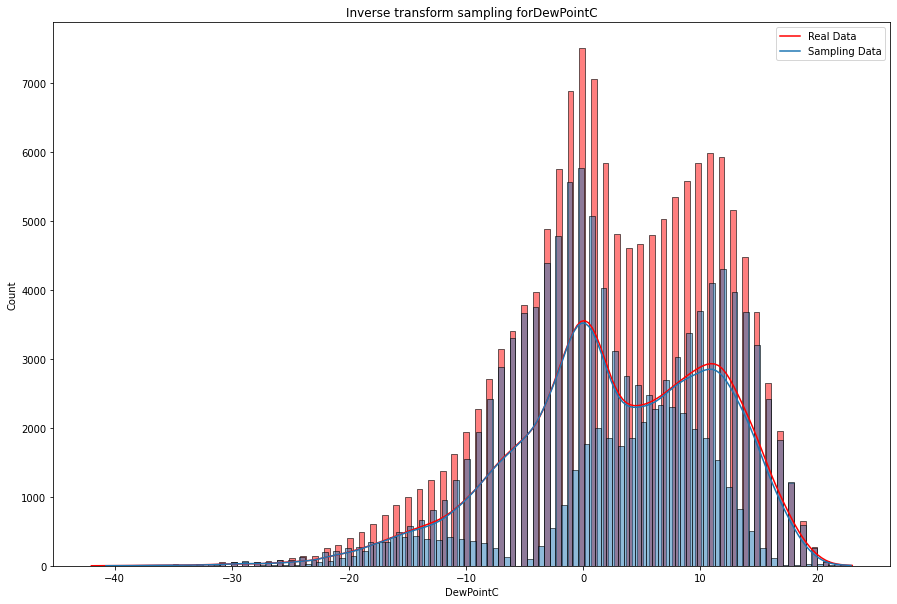

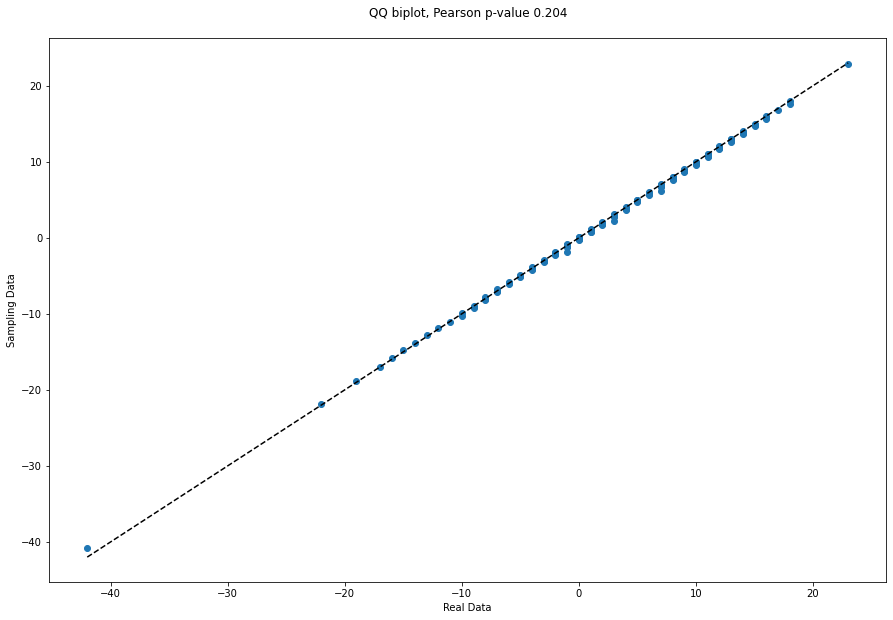

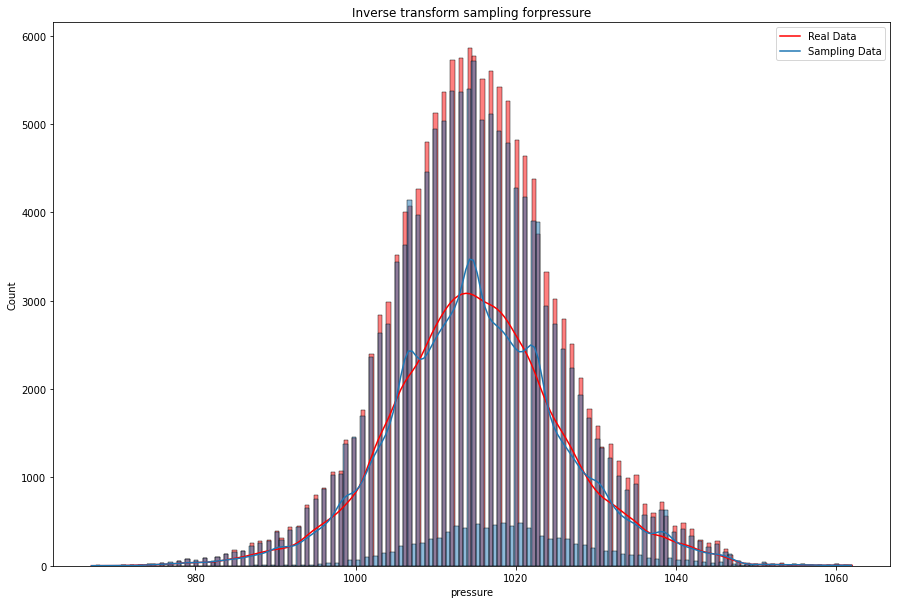

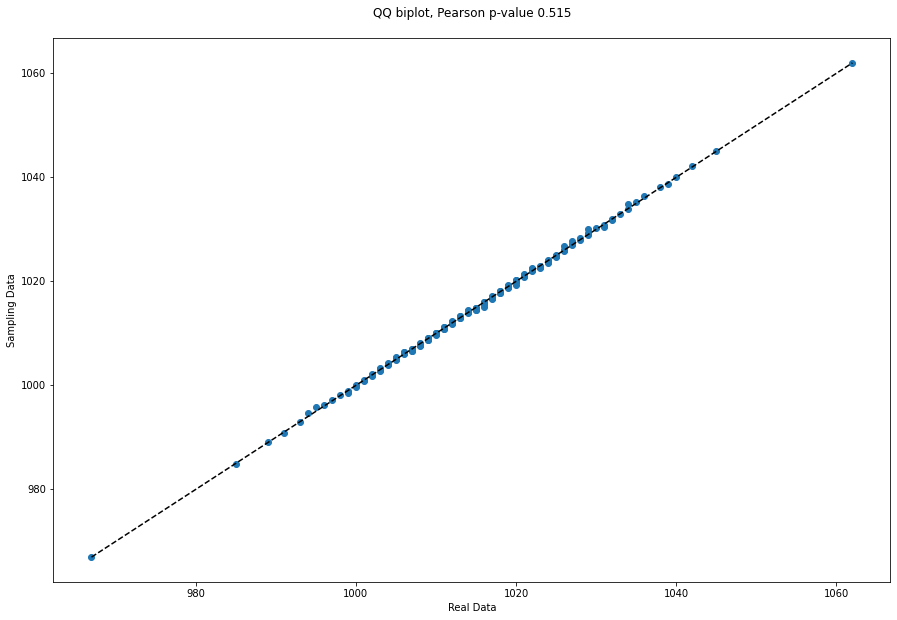

In [13]:
for name in targets_name:
    sampled, n_bins = inv_trans_sampling(df[name], num_samples=df[name].shape[0])

    percs = np.linspace(0, 100, n_bins)
    qn_gt = np.percentile(df[name], percs)
    qn_sampled = np.percentile(sampled, percs)

    p_stat, p_pv = scipy.stats.pearsonr(df[name], sampled)

    plt.figure(figsize=(15, 10))
    sns.histplot(df[name], bins=n_bins, kde=True, color='r')
    sns.histplot(sampled, bins=n_bins, kde=True)
    plt.legend(["Real Data", 'Sampling Data'])
    plt.title(f"Inverse transform sampling for{name}")
    plt.savefig(f'IV_plot_{name}', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
    plt.plot(qn_gt, qn_gt, color="k", ls="--")
    plt.xlabel("Real Data")
    plt.ylabel("Sampling Data")
    plt.title(f"QQ biplot, Pearson p-value {p_pv:.3f}\n")
    plt.savefig(f'Probability_plot_{name}', bbox_inches='tight')
    plt.show()

# Using accept-reject

In [ ]:
df['maxtempC'].describe()

count    142882.000000
mean          9.689555
std          11.661901
min         -36.000000
25%           1.000000
50%          10.000000
75%          20.000000
max          37.000000
Name: maxtempC, dtype: float64

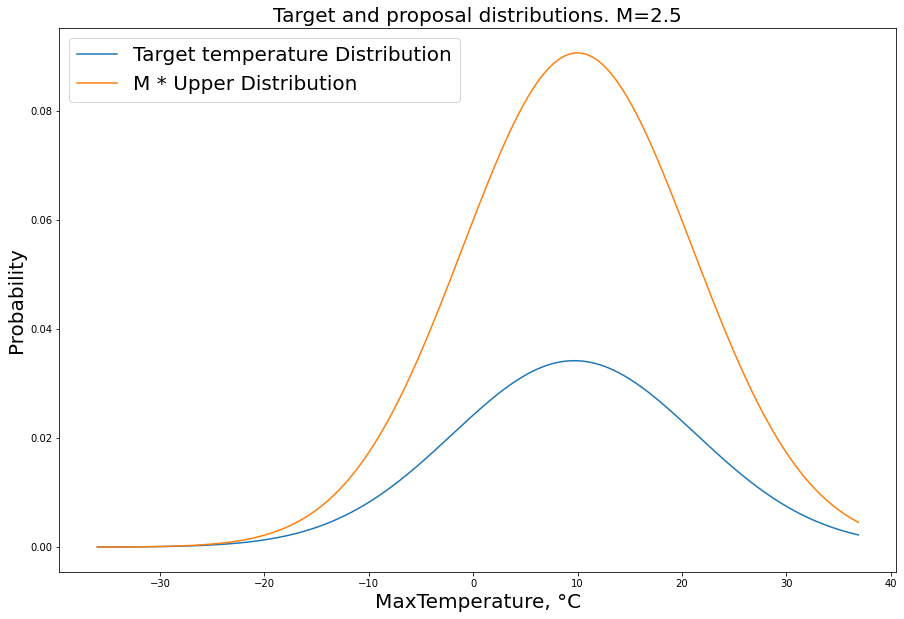

In [ ]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 2.5

upper_params = 10, 11

plt.figure(figsize=(15, 10))
x_vals = np.arange(-36, 37, 0.1)
f_vals = [g1(x, 9.689555, 11.661901) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('MaxTemperature, °C', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target temperature Distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
plt.savefig('Distib_temp', bbox_inches='tight')
plt.show()

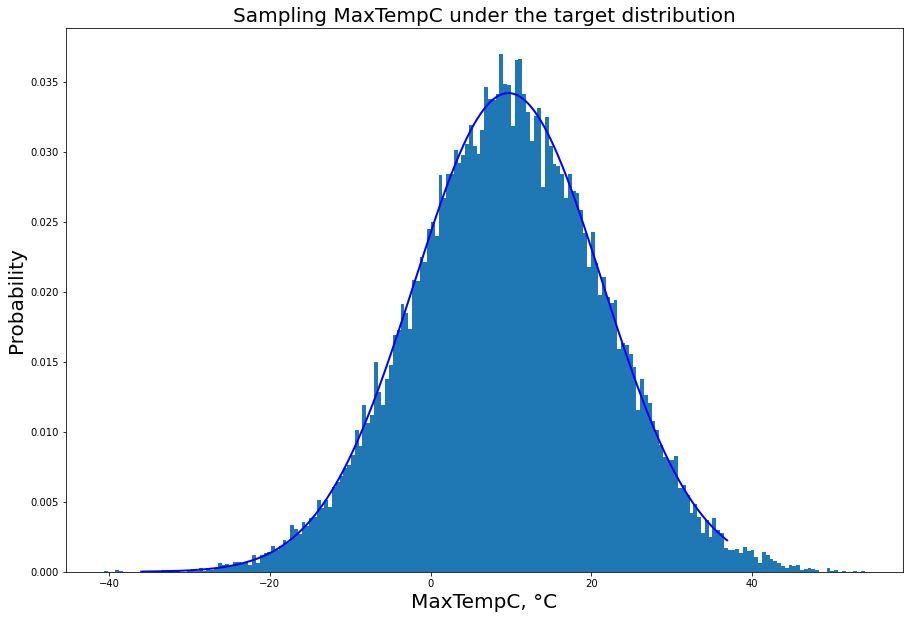

In [ ]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 80_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 9.689555, 11.661901) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.xlabel('MaxTempC, °C', fontsize=20)
plt.plot(x_vals, f_vals, linewidth=2, color='b')
plt.ylabel('Probability', fontsize=20)
plt.title("Sampling MaxTempC under the target distribution", fontsize=20)
plt.savefig('dist_hist_temp', bbox_inches='tight')
plt.show()

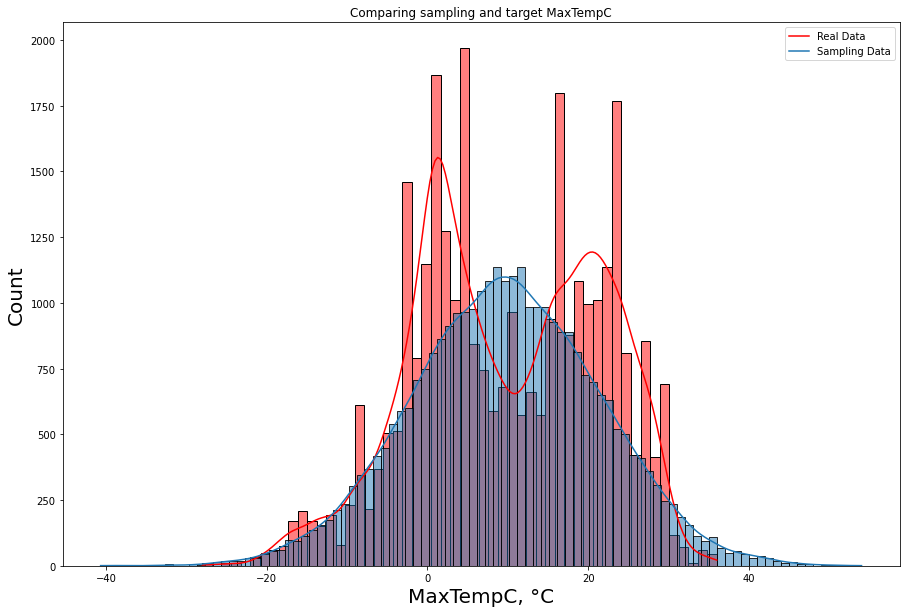

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(df['maxtempC'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title("Temperature.", fontsize=20)
plt.xlabel('MaxTempC, °C', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title(f"Comparing sampling and target MaxTempC")
plt.savefig('hist_temp', bbox_inches='tight')
plt.show()


0.004680873921148727


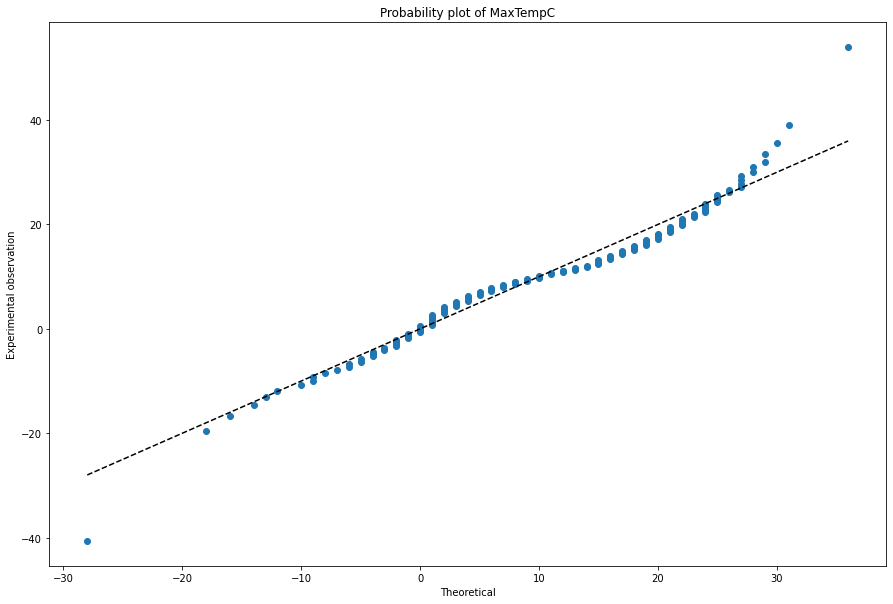

In [ ]:

plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['maxtempC'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['maxtempC'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of MaxTempC")
plt.savefig('Probability_plot_temp', bbox_inches='tight')
plt.show()

In [ ]:

df['DewPointC'].describe()

count    142882.000000
mean          2.688715
std           8.877535
min         -42.000000
25%          -3.000000
50%           3.000000
75%          10.000000
max          23.000000
Name: DewPointC, dtype: float64

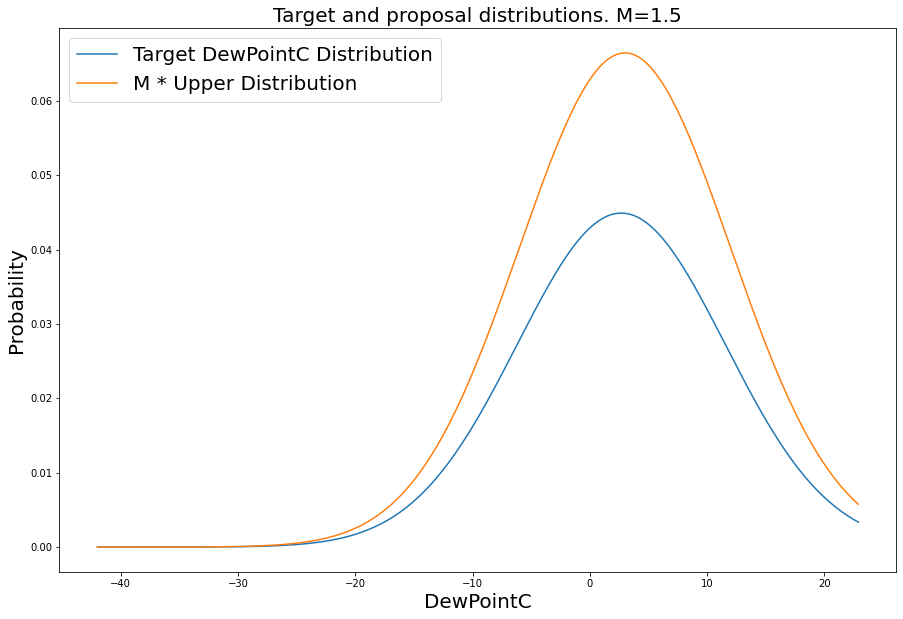

In [ ]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 1.5

upper_params = 3, 9

plt.figure(figsize=(15, 10))
x_vals = np.arange(-42, 23, 0.1)
f_vals = [g1(x, 2.6818715, 8.877535) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('DewPointC', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target DewPointC Distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
#plt.savefig('Distib_temp', bbox_inches='tight')
plt.show()

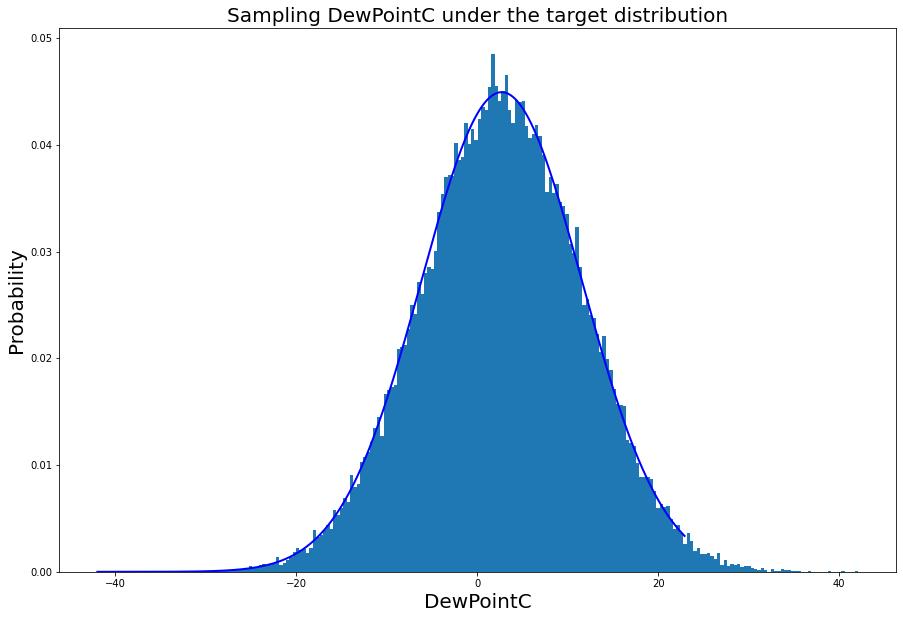

In [ ]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 80_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 2.6818715, 8.877535) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.xlabel('DewPointC', fontsize=20)
plt.plot(x_vals, f_vals, linewidth=2, color='b')
plt.ylabel('Probability', fontsize=20)
plt.title("Sampling DewPointC under the target distribution", fontsize=20)
#plt.savefig('dist_hist_temp', bbox_inches='tight')
plt.show()

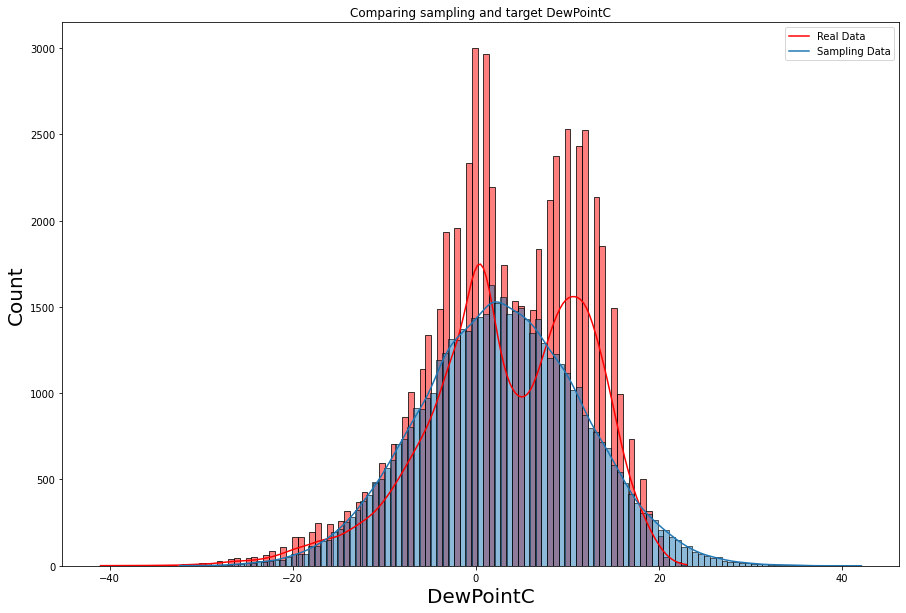

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(df['DewPointC'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title("DewPointC.", fontsize=20)
plt.xlabel('DewPointC', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title(f"Comparing sampling and target DewPointC")
#plt.savefig('hist_temp', bbox_inches='tight')
plt.show()


0.03475061659381843


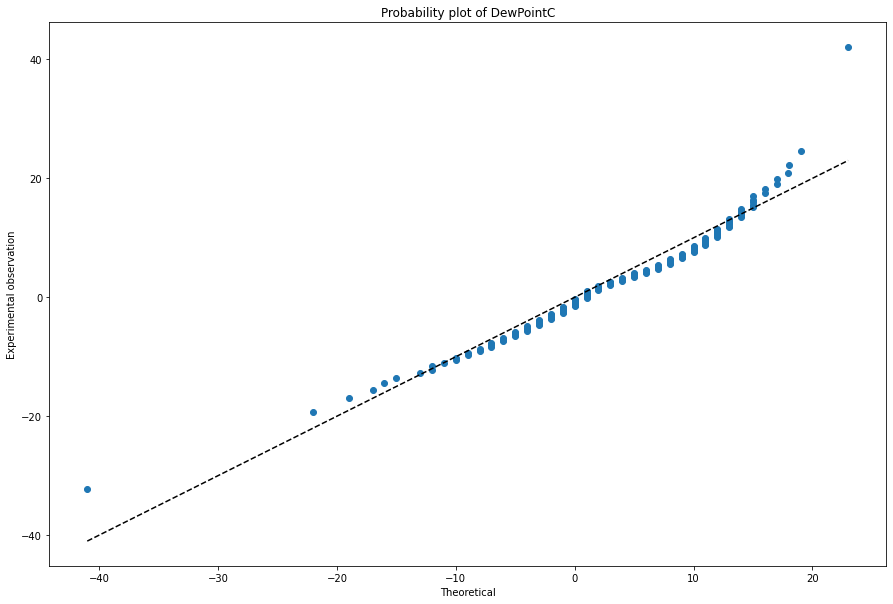

In [ ]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['DewPointC'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['DewPointC'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of DewPointC")
#plt.savefig('Probability_plot_temp', bbox_inches='tight')
plt.show()

In [ ]:
df['pressure'].describe()

count    142882.000000
mean       1015.126531
std          10.870944
min         967.000000
25%        1008.000000
50%        1015.000000
75%        1022.000000
max        1062.000000
Name: pressure, dtype: float64

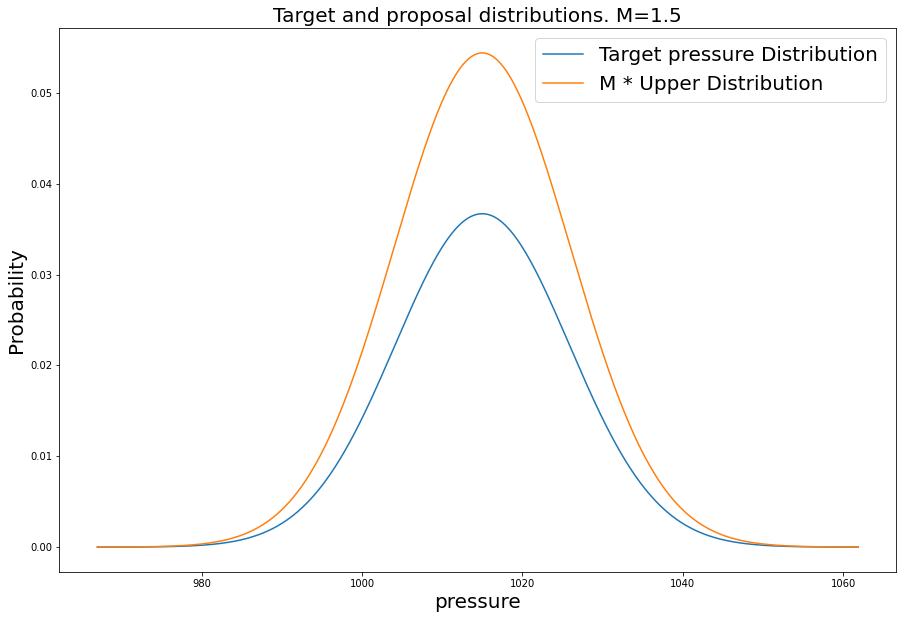

In [ ]:
def g1(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

def g(x, mu_, sigma_):
    return 1 / np.sqrt(2 * np.pi) / sigma_ * np.exp(-0.5 * ((x - mu_) / sigma_) ** 2)

M = 1.5

upper_params = 1015, 11

plt.figure(figsize=(15, 10))
x_vals = np.arange(967, 1062, 0.1)
f_vals = [g1(x, 1015.0, 10.870944) for x in x_vals]
g_vals = g(x_vals, *upper_params)
plt.plot(x_vals, f_vals)
plt.plot(x_vals, M * g_vals)
plt.xlabel('pressure', fontsize=20)
plt.ylabel('Probability', fontsize=20)
plt.legend(['Target pressure Distribution', 'M * Upper Distribution'], fontsize=20)
plt.title("Target and proposal distributions. M=%s" % M, fontsize=20)
#plt.savefig('Distib_temp', bbox_inches='tight')
plt.show()

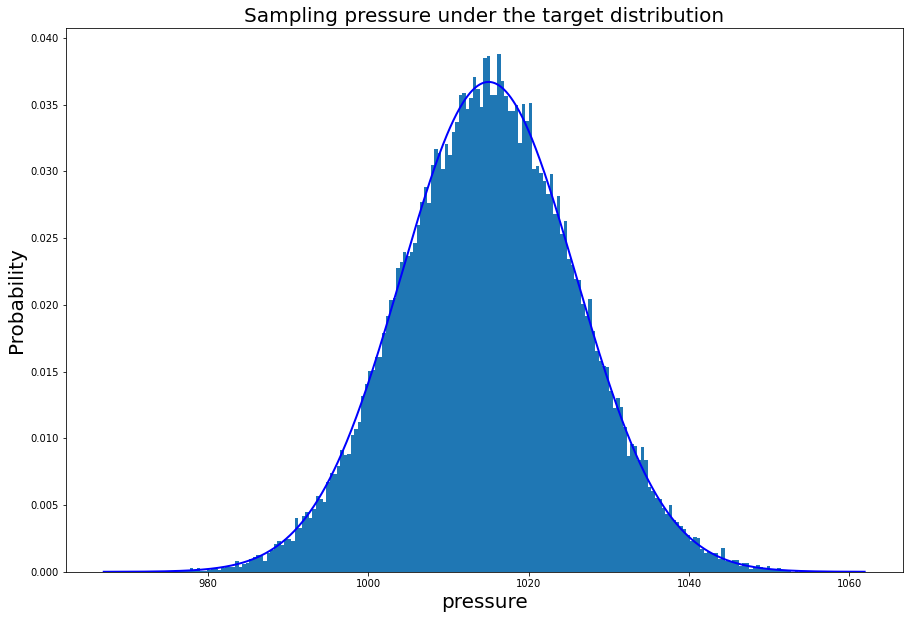

In [ ]:
# collect all accepted samples here
samples = []

# try this many candidates
N = 80_000

for _ in range(N):
    # sample a candidate
    candidate = np.random.normal(*upper_params)

    # calculate probability of accepting this candidate
    prob_accept = g1(candidate, 1015.126531, 10.870944) / (M * g(candidate, *upper_params))

    # accept with the calculated probability
    if np.random.random() < prob_accept:
        samples.append(candidate)

plt.figure(figsize=(15, 10))
plt.hist(samples, bins=200, density=True)
plt.xlabel('pressure', fontsize=20)
plt.plot(x_vals, f_vals, linewidth=2, color='b')
plt.ylabel('Probability', fontsize=20)
plt.title("Sampling pressure under the target distribution", fontsize=20)
#plt.savefig('dist_hist_temp', bbox_inches='tight')
plt.show()

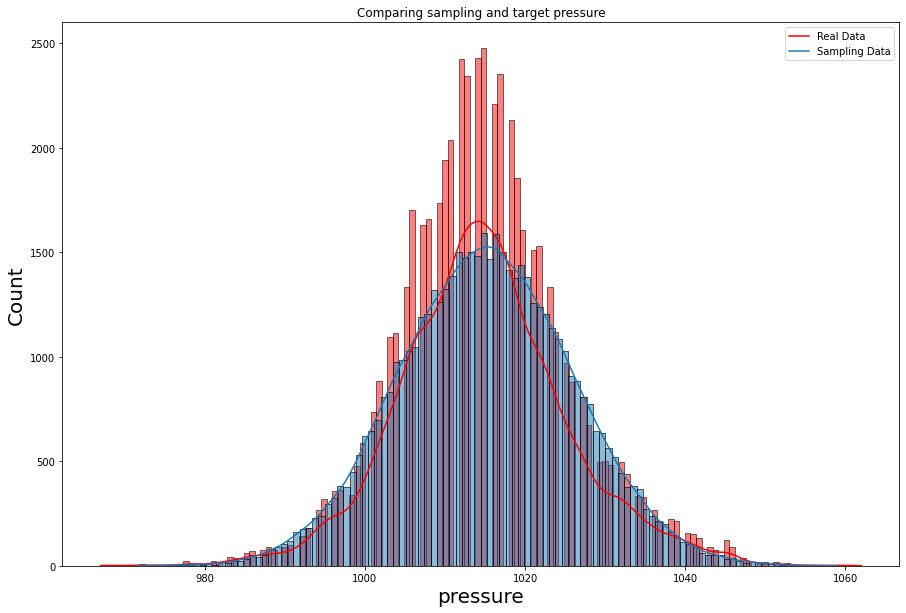

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(df['pressure'].values[:len(samples)], kde=True, color='red')
sns.histplot(samples, kde=True)
plt.legend(["Real Data", 'Sampling Data'])
plt.title("pressure.", fontsize=20)
plt.xlabel('pressure', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.title(f"Comparing sampling and target pressure")
#plt.savefig('hist_temp', bbox_inches='tight')
plt.show()


0.38459888522196206


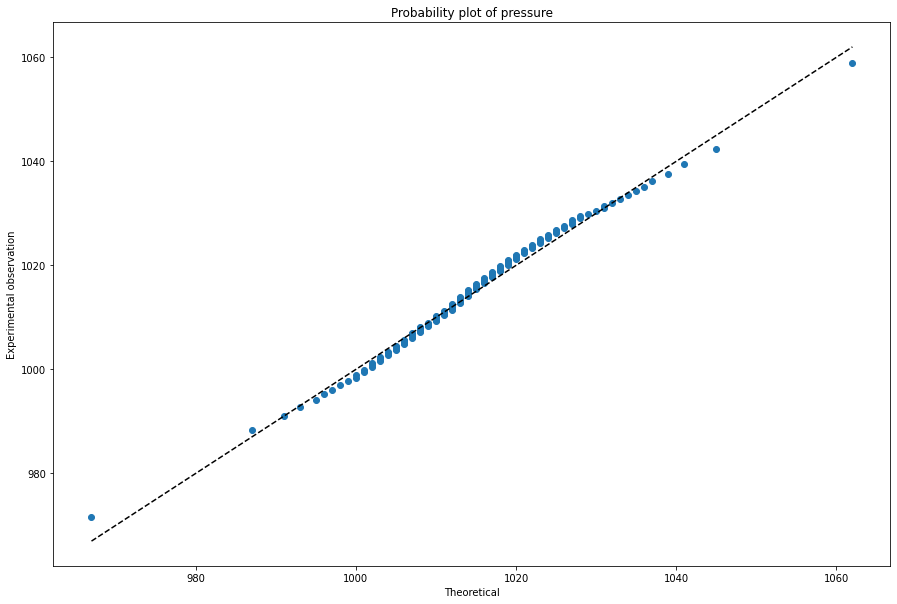

In [ ]:
plt.figure(figsize=(15, 10))
percs = np.linspace(0, 100, 150)
qn_gt = np.percentile(df['pressure'].values[:len(samples)], percs)
p_stat, p_pv = scipy.stats.pearsonr(df['pressure'].values[:len(samples)], samples)
print(p_pv)
qn_sampled = np.percentile(samples, percs)
plt.plot(qn_gt, qn_sampled, ls="", marker="o", markersize=6)
plt.plot(qn_gt, qn_gt, color="k", ls="--")
plt.xlabel('Theoretical')
plt.ylabel('Experimental observation')
plt.title("Probability plot of pressure")
#plt.savefig('Probability_plot_temp', bbox_inches='tight')
plt.show()

<ipython-input-49-a1d9b9f9249d>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


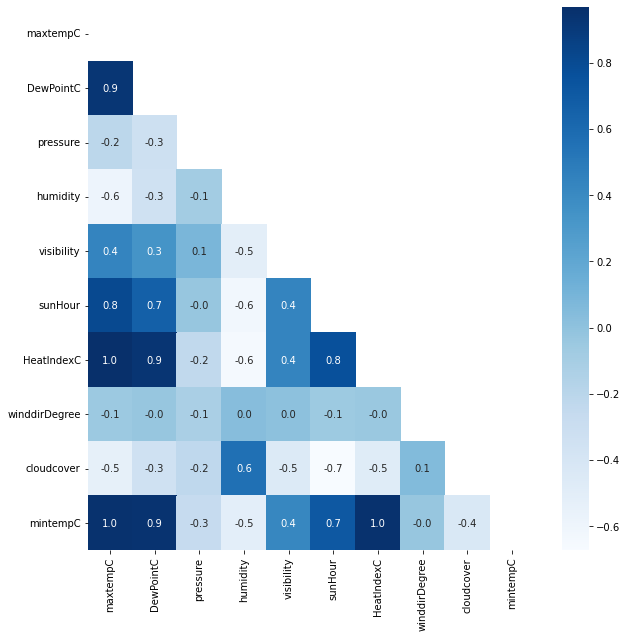

In [ ]:
# Building a correlation matrix of features
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask, annot=True, fmt='.1f', ax=ax, cmap='Blues')
plt.savefig('corrcoefs', bbox_inches='tight')

# Baysessian

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling

from pgmpy.estimators import BicScore

from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import TreeSearch
from sklearn.metrics import mean_absolute_percentage_error as mape
from collections import Counter
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [ ]:
#data preparation
df_trans = df.copy()
df_trans


,maxtempC,DewPointC,pressure,humidity,visibility,sunHour,HeatIndexC,winddirDegree,cloudcover,mintempC
0,0,-7,1011,96,2,2.8,-6,263,100,-6
1,-5,-12,1025,96,2,5.8,-12,212,68,-12
2,0,-6,1010,96,3,2.8,-6,268,100,-6
3,2,1,1008,97,5,1.5,1,271,91,1
4,0,-6,1010,96,3,2.8,-6,268,100,-6
...,...,...,...,...,...,...,...,...,...,...
142877,4,-3,1020,75,10,8.7,1,328,68,0
142878,-1,-9,1027,64,10,8.7,-4,107,9,-6
142879,3,1,1012,88,10,3.4,2,334,100,0
142880,-1,-9,1027,64,10,8.7,-4,107,9,-6


In [ ]:
data_keys = ['maxtempC', 'DewPointC', 'pressure', 'humidity', 'visibility', 'sunHour', 'HeatIndexC', 'winddirDegree', 'cloudcover', 'mintempC']
data = df_trans[data_keys]
data = data.dropna()

discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="kmeans")

data_descrete = discretizer.fit_transform(data.values)
data_descrete = pd.DataFrame(data_descrete, columns=data_keys)

data_descrete.head()

,maxtempC,DewPointC,pressure,humidity,visibility,sunHour,HeatIndexC,winddirDegree,cloudcover,mintempC
0,2.0,2.0,2.0,4.0,0.0,0.0,1.0,3.0,4.0,2.0
1,1.0,1.0,3.0,4.0,0.0,1.0,0.0,2.0,3.0,1.0
2,2.0,2.0,1.0,4.0,1.0,0.0,1.0,3.0,4.0,2.0
3,2.0,3.0,1.0,4.0,2.0,0.0,2.0,3.0,4.0,2.0
4,2.0,2.0,1.0,4.0,1.0,0.0,1.0,3.0,4.0,2.0


In [ ]:
def get_scores(data, samples, descritizer=discretizer):

    data_continious = descritizer.inverse_transform(data.values)
    data_continious = pd.DataFrame(data_continious, columns=data_keys)
    sample_continious = descritizer.inverse_transform(samples.values)
    sample_continious = pd.DataFrame(sample_continious, columns=data_keys)

    y_true = np.sort(data_continious['maxtempC'].iloc[:2000].values)
    y_pred = np.sort(sample_continious['maxtempC'].iloc[:2000].values)

    corr_matrix = np.corrcoef(y_true, y_pred)
    corr = corr_matrix[0,1]
    R_sq = corr**2

    print(f'R-2 score is: {R_sq}')
    print(f'RMSE is: {sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'MAE is: {mean_absolute_error(y_true, y_pred)}')
    return R_sq, sqrt(mean_squared_error(y_true, y_pred)), mape(y_true, y_pred)


In [ ]:
data_rmse = []
data_mape = []
data_r2 = []


In [ ]:

# modeling edges based on the analisys from step 3

model = BayesianModel([
    ('DewPointC', 'mintempC'),
    ('DewPointC', 'sunHour'),
    ('maxtempC', 'sunHour'),
    ('maxtempC', 'HeatIndexC'),
    ('pressure', 'humidity'),
    ('pressure', 'mintempC'),
    ('maxtempC', 'humidity'),
    ('DewPointC','visibility'),
    ('DewPointC', 'winddirDegree'),
    ('pressure', 'cloudcover')
])

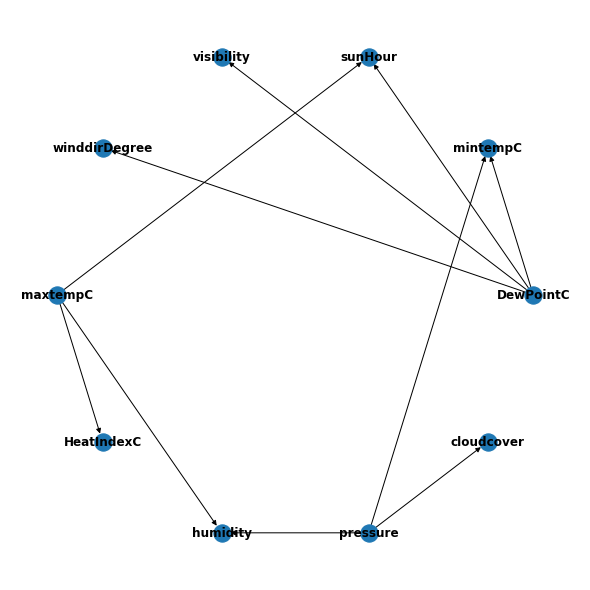

In [ ]:
network = nx.DiGraph()
network.add_edges_from(model.edges())
pos = nx.layout.circular_layout(network)
plt.figure(figsize=(8, 8))
nx.draw(network, pos, with_labels=True, font_weight="bold")

In [ ]:
df_trans = df.copy()

est = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
data_discr = est.fit_transform(df_trans.values[:, :])
df_trans[df_trans.columns[:]] = data_discr

df_prob = df_trans.iloc[:2000, :].copy()
df_trans = df_trans.iloc[2000:,:].copy()

In [ ]:
model.fit(df_trans)

print(model.check_model())

True


In [ ]:

k2_scores = {}

k2_scores["manual"] = K2Score(df_trans).score(model)
print(f"K2 score of hand-crafted model {K2Score(df_trans).score(model):.2f}")
print(f"BIC score of hand-crafted model {BicScore(df_trans).score(model):.2f}")

K2 score of hand-crafted model -1669895.13
BIC score of hand-crafted model -1670559.16


In [ ]:
def sampling(bn: DAG, data: pd.DataFrame, n: int = 100, new: bool = False):
    if new:
        bn_new = BayesianModel(bn.edges())
        bn_new.fit(data)
    else:
        bn_new = bn
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n)
    return sample

In [ ]:
df_s1 = sampling(model, df_prob, n=2000, new=True)
df_s1

/usr/local/lib/python3.8/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

,DewPointC,mintempC,sunHour,visibility,winddirDegree,maxtempC,HeatIndexC,humidity,pressure,cloudcover
0,3.0,2.0,2.0,0.0,3.0,1.0,1.0,4.0,3.0,4.0
1,2.0,1.0,0.0,3.0,3.0,2.0,2.0,4.0,3.0,4.0
2,3.0,2.0,1.0,2.0,3.0,1.0,0.0,4.0,4.0,3.0
3,3.0,2.0,0.0,0.0,2.0,1.0,0.0,4.0,3.0,3.0
4,3.0,2.0,0.0,4.0,3.0,1.0,1.0,4.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...
1995,1.0,1.0,1.0,4.0,0.0,1.0,1.0,4.0,0.0,3.0
1996,2.0,1.0,0.0,2.0,3.0,1.0,1.0,4.0,3.0,4.0
1997,1.0,1.0,0.0,4.0,2.0,2.0,1.0,4.0,1.0,4.0
1998,2.0,2.0,0.0,4.0,2.0,2.0,2.0,4.0,2.0,4.0


In [ ]:
get_scores(df_trans, df_s1)


R-2 score is: 0.5986366020546656
RMSE is: 5.75482873579264
MAE is: 2.6784639340435907


(0.5986366020546656, 5.75482873579264, 0.6308471285891498)

In [ ]:
r2, rmse, mae = get_scores(df_trans, df_s1)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.5986366020546656
RMSE is: 5.75482873579264
MAE is: 2.6784639340435907


In [ ]:
search = TreeSearch(df_trans, root_node="maxtempC")
tree = search.estimate()

Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

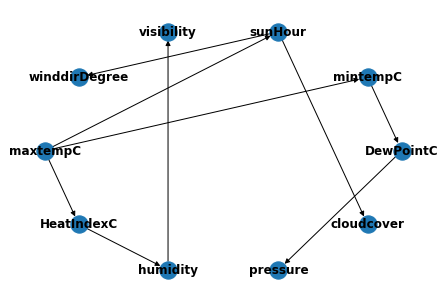

In [ ]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(tree.edges())
nx.draw(G_K2, pos, with_labels=True, font_weight='bold')

In [ ]:
k2_scores["tree"] = K2Score(df_trans).score(tree)

print(f"K2 score of tree model {K2Score(df_trans).score(tree):.2f}")
print(f"BIC score of tree model {BicScore(df_trans).score(tree):.2f}")


K2 score of tree model -1489893.40
BIC score of tree model -1489953.04


In [ ]:
df_stree = sampling(tree, df_prob, n=2000, new=True)
get_scores(df_trans, df_stree)

/usr/local/lib/python3.8/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

R-2 score is: 0.455370589218839
RMSE is: 7.60743758779253
MAE is: 4.750209760003916


(0.455370589218839, 7.60743758779253, 1.1092530680300206)

In [ ]:
r2, rmse, mae = get_scores(df_trans, df_stree)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.455370589218839
RMSE is: 7.60743758779253
MAE is: 4.750209760003916


In [ ]:

search = HillClimbSearch(df_trans)
k2_unconstr = search.estimate()


  0%|          | 0/1000000 [00:00<?, ?it/s]

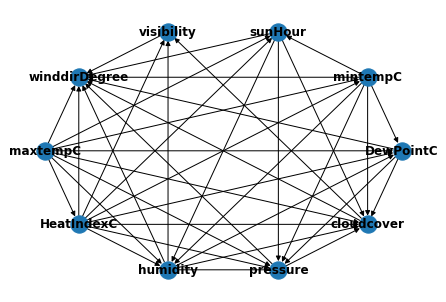

In [ ]:

G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_unconstr.edges())
nx.draw(G_K2, pos, with_labels=True, font_weight='bold')

In [ ]:
k2_scores["k2_unconstr"] = K2Score(df_trans).score(k2_unconstr)

print(f"K2 score of unconstrained model {K2Score(df_trans).score(k2_unconstr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_trans).score(k2_unconstr):.2f}")

K2 score of unconstrained model -1380359.14
BIC score of unconstrained model -49886243.68


In [ ]:
df_k2c = sampling(k2_unconstr, df_prob, n=2000, new=True)
get_scores(df_trans, df_k2c)


/usr/local/lib/python3.8/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

R-2 score is: 0.45422822120957046
RMSE is: 7.881120544482058
MAE is: 5.066649408649334


(0.45422822120957046, 7.881120544482058, 1.1793015199241752)

In [ ]:
r2, rmse, mae = get_scores(df_trans, df_k2c)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.45422822120957046
RMSE is: 7.881120544482058
MAE is: 5.066649408649334


NJJJJJ

In [ ]:
blacklist = []
blacklist.extend([(x, y) for x in df_trans.columns.to_list() for y in ['humidity', 'visibility', 'sunHour', 'HeatIndexC', 'winddirDegree', 'cloudcover', 'mintempC'] if x != y])
blacklist.extend([(y, x) for x in df_trans.columns.to_list() for y in ['maxtempC', 'DewPointC', 'pressure']])

# рассказать про фиксацию ребер

In [ ]:
search = HillClimbSearch(df_trans)
k2_constr = search.estimate(black_list=blacklist, fixed_edges=[('DewPointC', 'mintempC'), ('DewPointC', 'sunHour'), ('maxtempC', 'sunHour'), ('maxtempC', 'HeatIndexC'), ('pressure', 'humidity'), ('pressure', 'mintempC'), ('maxtempC', 'humidity'), ('DewPointC','visibility'), ('DewPointC', 'winddirDegree'), ('pressure', 'cloudcover')])

  0%|          | 0/1000000 [00:00<?, ?it/s]

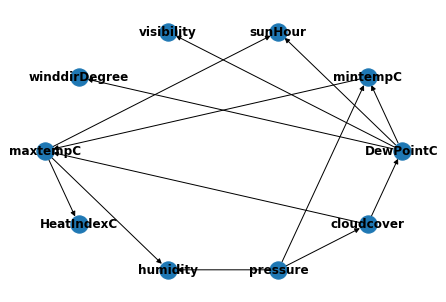

In [ ]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(k2_constr.edges())
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')


In [ ]:
k2_scores["k2_constr"] = K2Score(df_trans).score(k2_constr)

print(f"K2 score of unconstrained model {K2Score(df_trans).score(k2_constr):.2f}")
print(f"BIC score of unconstrained model {BicScore(df_trans).score(k2_constr):.2f}")

K2 score of unconstrained model -1536499.07
BIC score of unconstrained model -1537201.37


In [ ]:
df_k2c = sampling(k2_constr, df_prob, n=7000, new=True)
get_scores(df_trans, df_k2c)

/usr/local/lib/python3.8/dist-packages/pgmpy/models/BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


  0%|          | 0/10 [00:00<?, ?it/s]

R-2 score is: 0.4392065942168324
RMSE is: 7.480570759513362
MAE is: 4.712417477026124


(0.4392065942168324, 7.480570759513362, 1.1149980169272837)

In [ ]:
r2, rmse, mae = get_scores(df_trans, df_k2c)
data_r2.append(r2)
data_rmse.append(rmse)
data_mape.append(mae)

R-2 score is: 0.4392065942168324
RMSE is: 7.480570759513362
MAE is: 4.712417477026124


In [ ]:
data_mape

[0.6308471285891498,
 1.1092530680300206,
 1.1793015199241752,
 1.1149980169272837]

In [ ]:
data_r2

[0.5986366020546656,
 0.455370589218839,
 0.45422822120957046,
 0.4392065942168324]

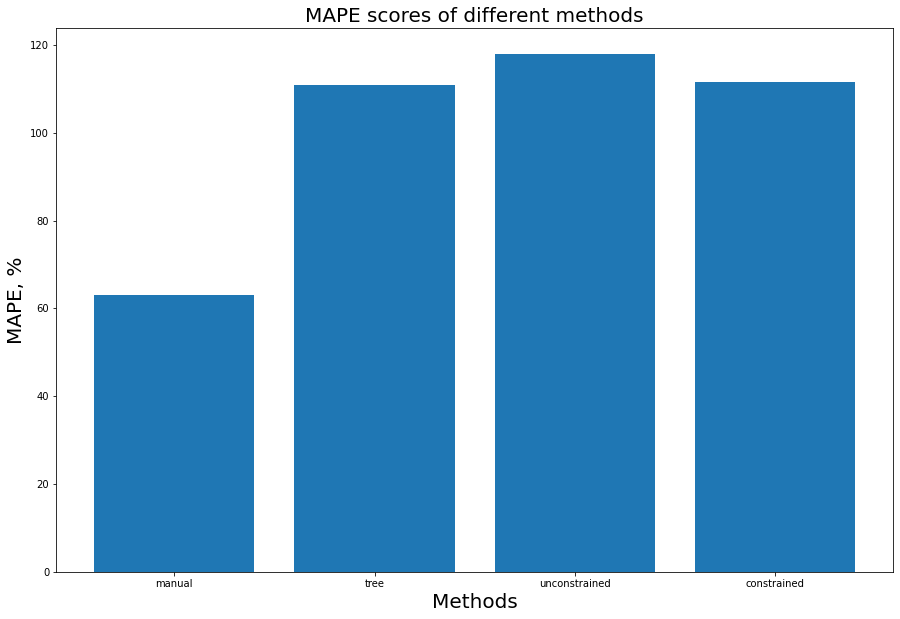

In [ ]:
plt.figure(figsize=(15, 10))
#x = ["manual", "tree", "unconstrained","constrained","chto"]
x = ["manual", "tree", "unconstrained","constrained"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, [i*100 for i in data_mape])
plt.title('MAPE scores of different methods', fontsize=20)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('MAPE, %', fontsize=20)
# plt.ylim(0.82, 0.95)
#plt.savefig('./Pictures/MAPE scores of different methods_scale_1', bbox_inches='tight')
plt.show()

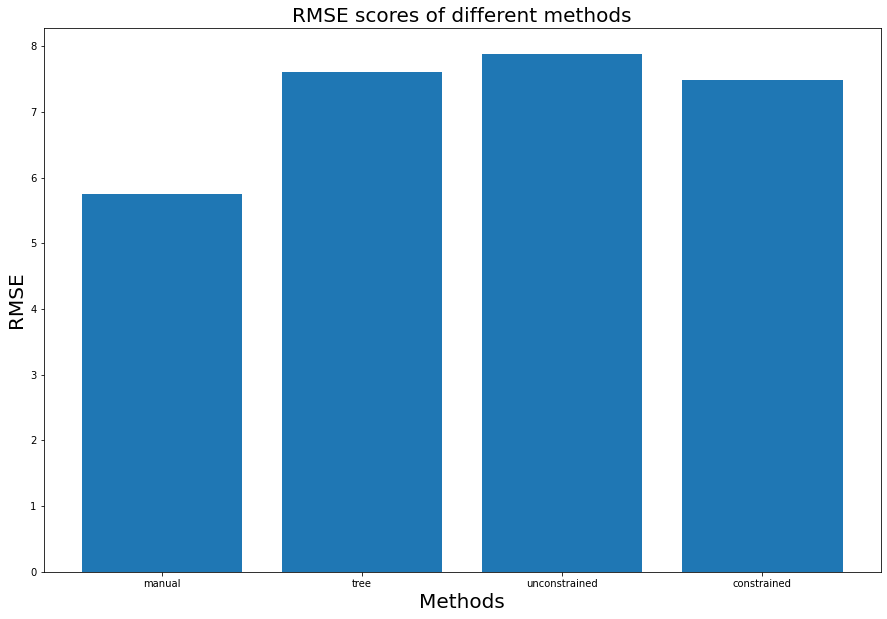

In [ ]:
plt.figure(figsize=(15, 10))
x = ["manual", "tree", "unconstrained","constrained"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, data_rmse)
plt.title('RMSE scores of different methods', fontsize=20)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
# plt.ylim(0.82, 0.95)
#plt.savefig('./Pictures/RMSE scores of different methods_scale_1', bbox_inches='tight')
plt.show()

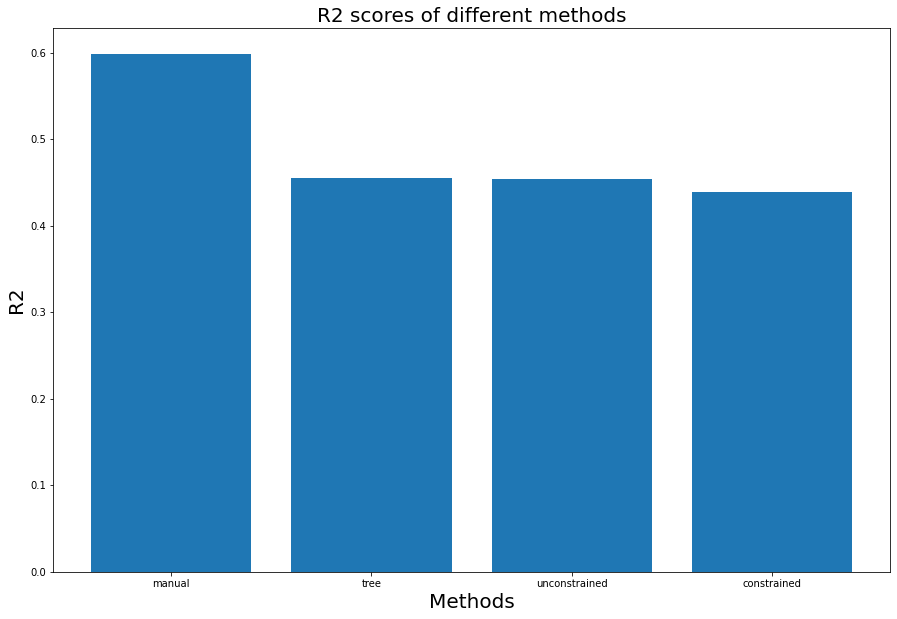

In [ ]:
plt.figure(figsize=(15, 10))
x = ["manual", "tree", "unconstrained","constrained"]
# y = [0.8242023774658618, 0.8898068766957087, 0.9200255171923536]
# y = data_aucs.values
plt.bar(x, data_r2)
plt.title('R2 scores of different methods', fontsize=20)
plt.xlabel('Methods', fontsize=20)
plt.ylabel('R2', fontsize=20)
# plt.ylim(0.82, 0.95)
#plt.savefig('./Pictures/R2 scores of different methods_scale_1', bbox_inches='tight')
plt.show()